# Imports

In [200]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
import optuna
from rlearn.nn import NNModel, FC
from rlearn.tree import RandomForestClassifier, GradientBoostClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import (
    f1_score,
    roc_auc_score,
    classification_report,
    accuracy_score,
)
from sklearn.model_selection import StratifiedKFold
from rlearn.linear_model import Perceptron, ElasticNet
from rlearn.activation_functions import Softmax
from rlearn.solvers import StochasticGradientDescent, GradientDescent, Adam
import pickle

In [2]:
pd.set_option("display.float_format", lambda x: "%.3f" % x)

# Loading data

In [3]:
data = pd.read_csv("creditcard.csv")
data.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.000,-1.360,-0.073,2.536,1.378,-0.338,0.462,0.240,0.099,0.364,...,-0.018,0.278,-0.110,0.067,0.129,-0.189,0.134,-0.021,149.620,0
1,0.000,1.192,0.266,0.166,0.448,0.060,-0.082,-0.079,0.085,-0.255,...,-0.226,-0.639,0.101,-0.340,0.167,0.126,-0.009,0.015,2.690,0
2,1.000,-1.358,-1.340,1.773,0.380,-0.503,1.800,0.791,0.248,-1.515,...,0.248,0.772,0.909,-0.689,-0.328,-0.139,-0.055,-0.060,378.660,0
3,1.000,-0.966,-0.185,1.793,-0.863,-0.010,1.247,0.238,0.377,-1.387,...,-0.108,0.005,-0.190,-1.176,0.647,-0.222,0.063,0.061,123.500,0
4,2.000,-1.158,0.878,1.549,0.403,-0.407,0.096,0.593,-0.271,0.818,...,-0.009,0.798,-0.137,0.141,-0.206,0.502,0.219,0.215,69.990,0


In [4]:
data.rename(columns={"Class": "y"}, inplace=True)

In [5]:
data.drop("Time", axis=1, inplace=True)

In [6]:
data.duplicated().sum()

9144

In [7]:
data.drop_duplicates(inplace=True)

In [8]:
data.isna().sum()

V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
y         0
dtype: int64

# Data summary

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 275663 entries, 0 to 284806
Data columns (total 30 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   V1      275663 non-null  float64
 1   V2      275663 non-null  float64
 2   V3      275663 non-null  float64
 3   V4      275663 non-null  float64
 4   V5      275663 non-null  float64
 5   V6      275663 non-null  float64
 6   V7      275663 non-null  float64
 7   V8      275663 non-null  float64
 8   V9      275663 non-null  float64
 9   V10     275663 non-null  float64
 10  V11     275663 non-null  float64
 11  V12     275663 non-null  float64
 12  V13     275663 non-null  float64
 13  V14     275663 non-null  float64
 14  V15     275663 non-null  float64
 15  V16     275663 non-null  float64
 16  V17     275663 non-null  float64
 17  V18     275663 non-null  float64
 18  V19     275663 non-null  float64
 19  V20     275663 non-null  float64
 20  V21     275663 non-null  float64
 21  V22     275663 

In [10]:
data.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,y
count,275663.000,275663.000,275663.000,275663.000,275663.000,275663.000,275663.000,275663.000,275663.000,275663.000,...,275663.000,275663.000,275663.000,275663.000,275663.000,275663.000,275663.000,275663.000,275663.000,275663.000
mean,-0.037,-0.002,0.026,-0.004,-0.011,-0.014,0.009,-0.006,-0.012,0.003,...,0.003,0.006,-0.002,-0.007,-0.005,-0.000,0.002,0.001,90.578,0.002
std,1.953,1.667,1.508,1.424,1.378,1.313,1.240,1.192,1.100,1.087,...,0.733,0.726,0.631,0.606,0.524,0.484,0.401,0.333,253.214,0.041
min,-56.408,-72.716,-48.326,-5.683,-113.743,-26.161,-43.557,-73.217,-13.434,-24.588,...,-34.830,-10.933,-44.808,-2.837,-10.295,-2.605,-22.566,-15.430,0.000,0.000
25%,-0.941,-0.614,-0.843,-0.863,-0.700,-0.766,-0.552,-0.210,-0.660,-0.539,...,-0.225,-0.532,-0.165,-0.361,-0.324,-0.328,-0.072,-0.053,6.300,0.000
50%,-0.060,0.070,0.201,-0.035,-0.061,-0.271,0.045,0.023,-0.065,-0.092,...,-0.026,0.013,-0.014,0.038,0.010,-0.057,0.003,0.012,23.740,0.000
75%,1.294,0.819,1.048,0.754,0.605,0.388,0.584,0.322,0.593,0.471,...,0.189,0.534,0.145,0.433,0.347,0.244,0.095,0.081,79.910,0.000
max,2.455,22.058,9.383,16.875,34.802,73.302,120.589,20.007,15.595,23.745,...,27.203,10.503,22.528,4.585,7.520,3.517,31.612,33.848,25691.160,1.000


# Data distribution

In [11]:
cols_wo_y = data.columns.to_list()
cols_wo_y.remove("y")
cols_wo_y

['V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V13',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19',
 'V20',
 'V21',
 'V22',
 'V23',
 'V24',
 'V25',
 'V26',
 'V27',
 'V28',
 'Amount']

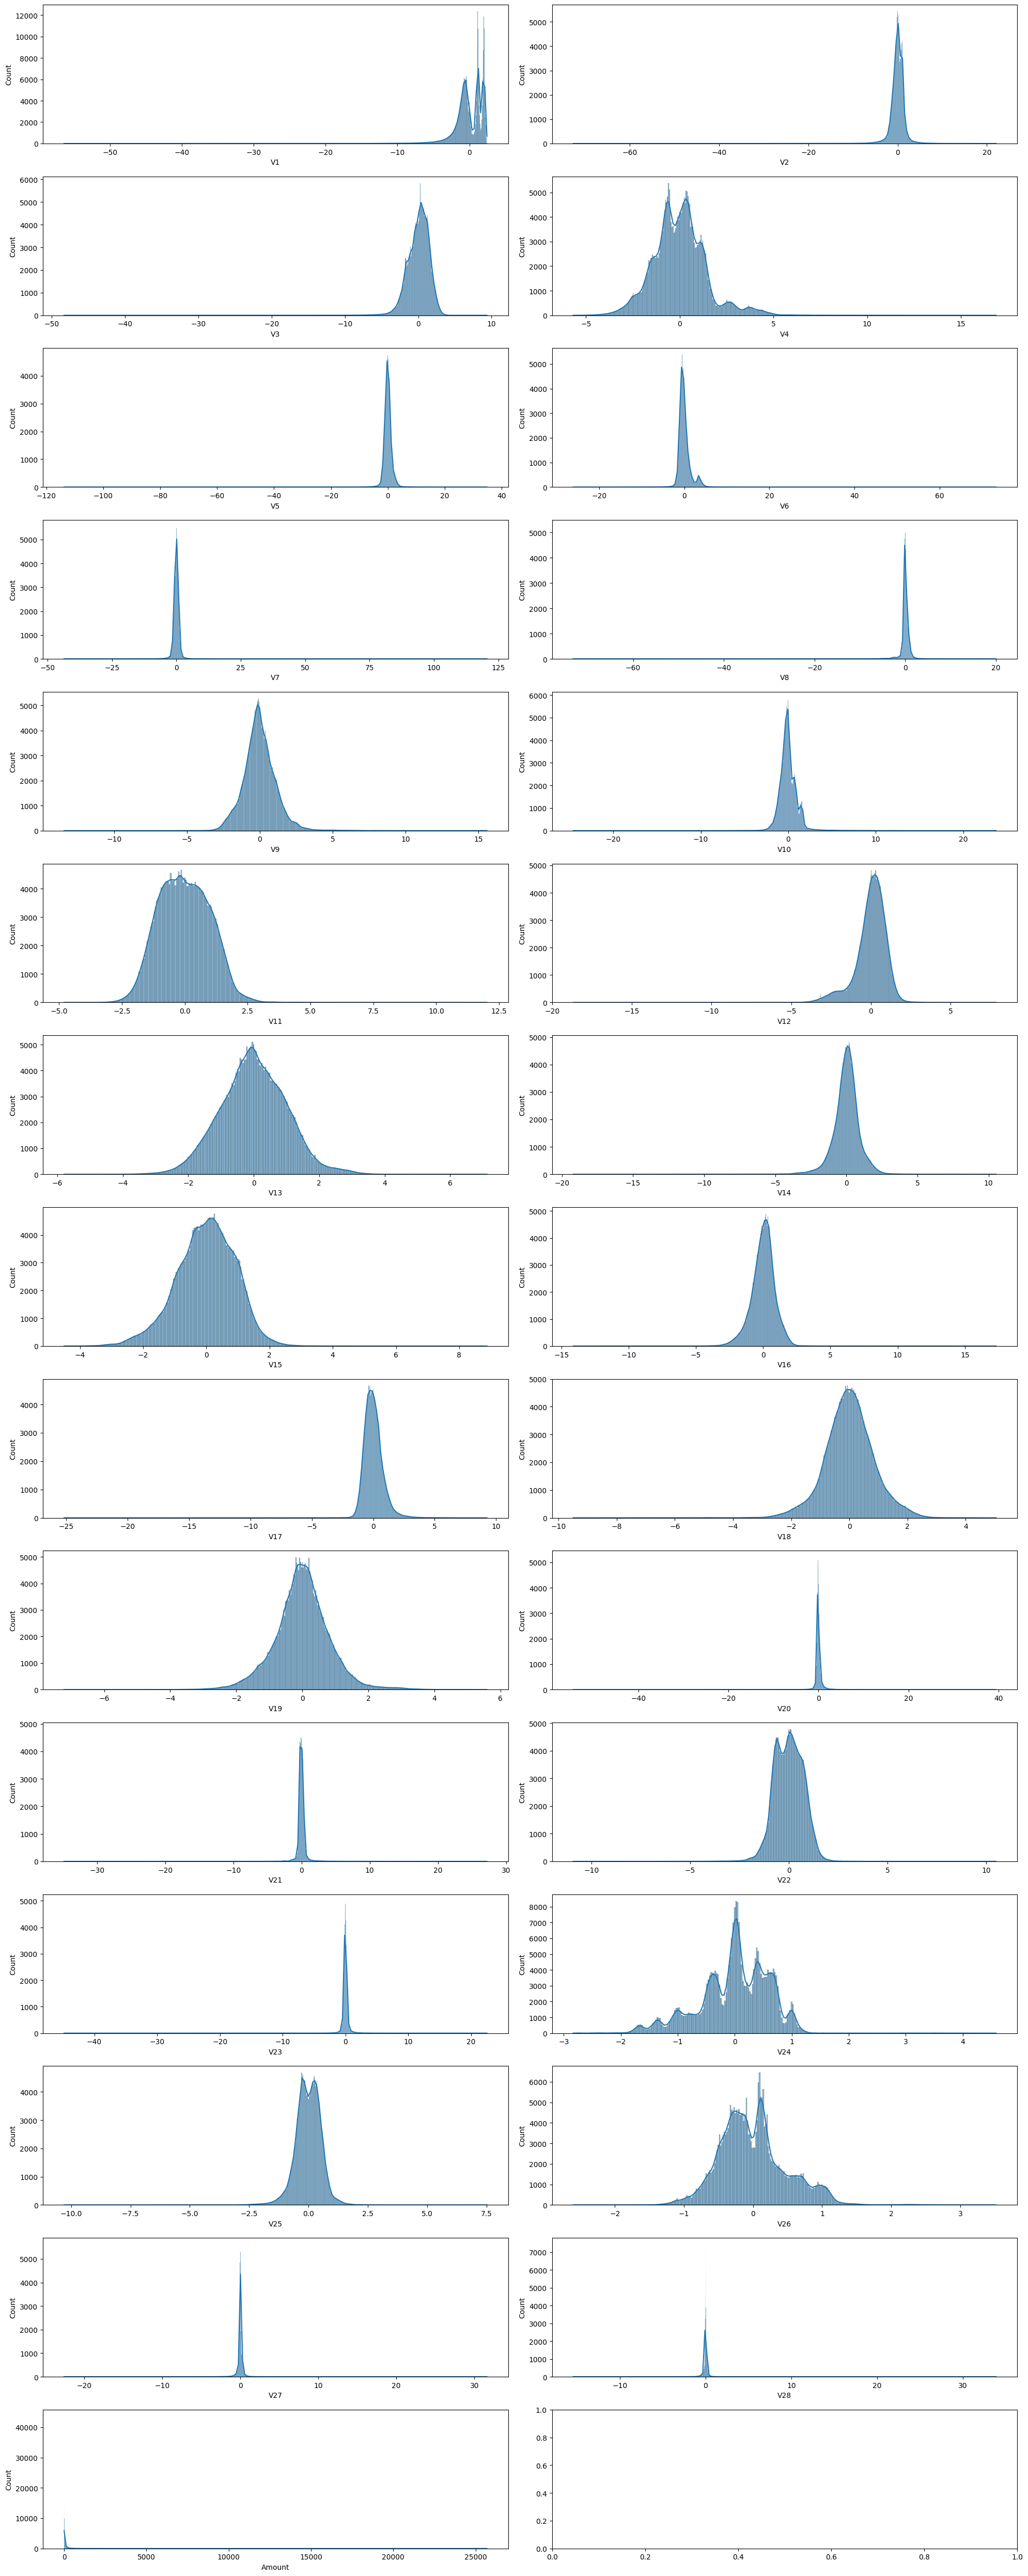

In [12]:
fig, axs = plt.subplots(nrows=int(len(cols_wo_y) / 2) + 1, ncols=2, figsize=(20, 50))
axs = axs.flatten()
for i, col in enumerate(cols_wo_y):
    sns.histplot(data[col], kde=True, ax=axs[i])
plt.tight_layout()

# Correlation

In [13]:
pearson_corr = data.corr()

<Axes: >

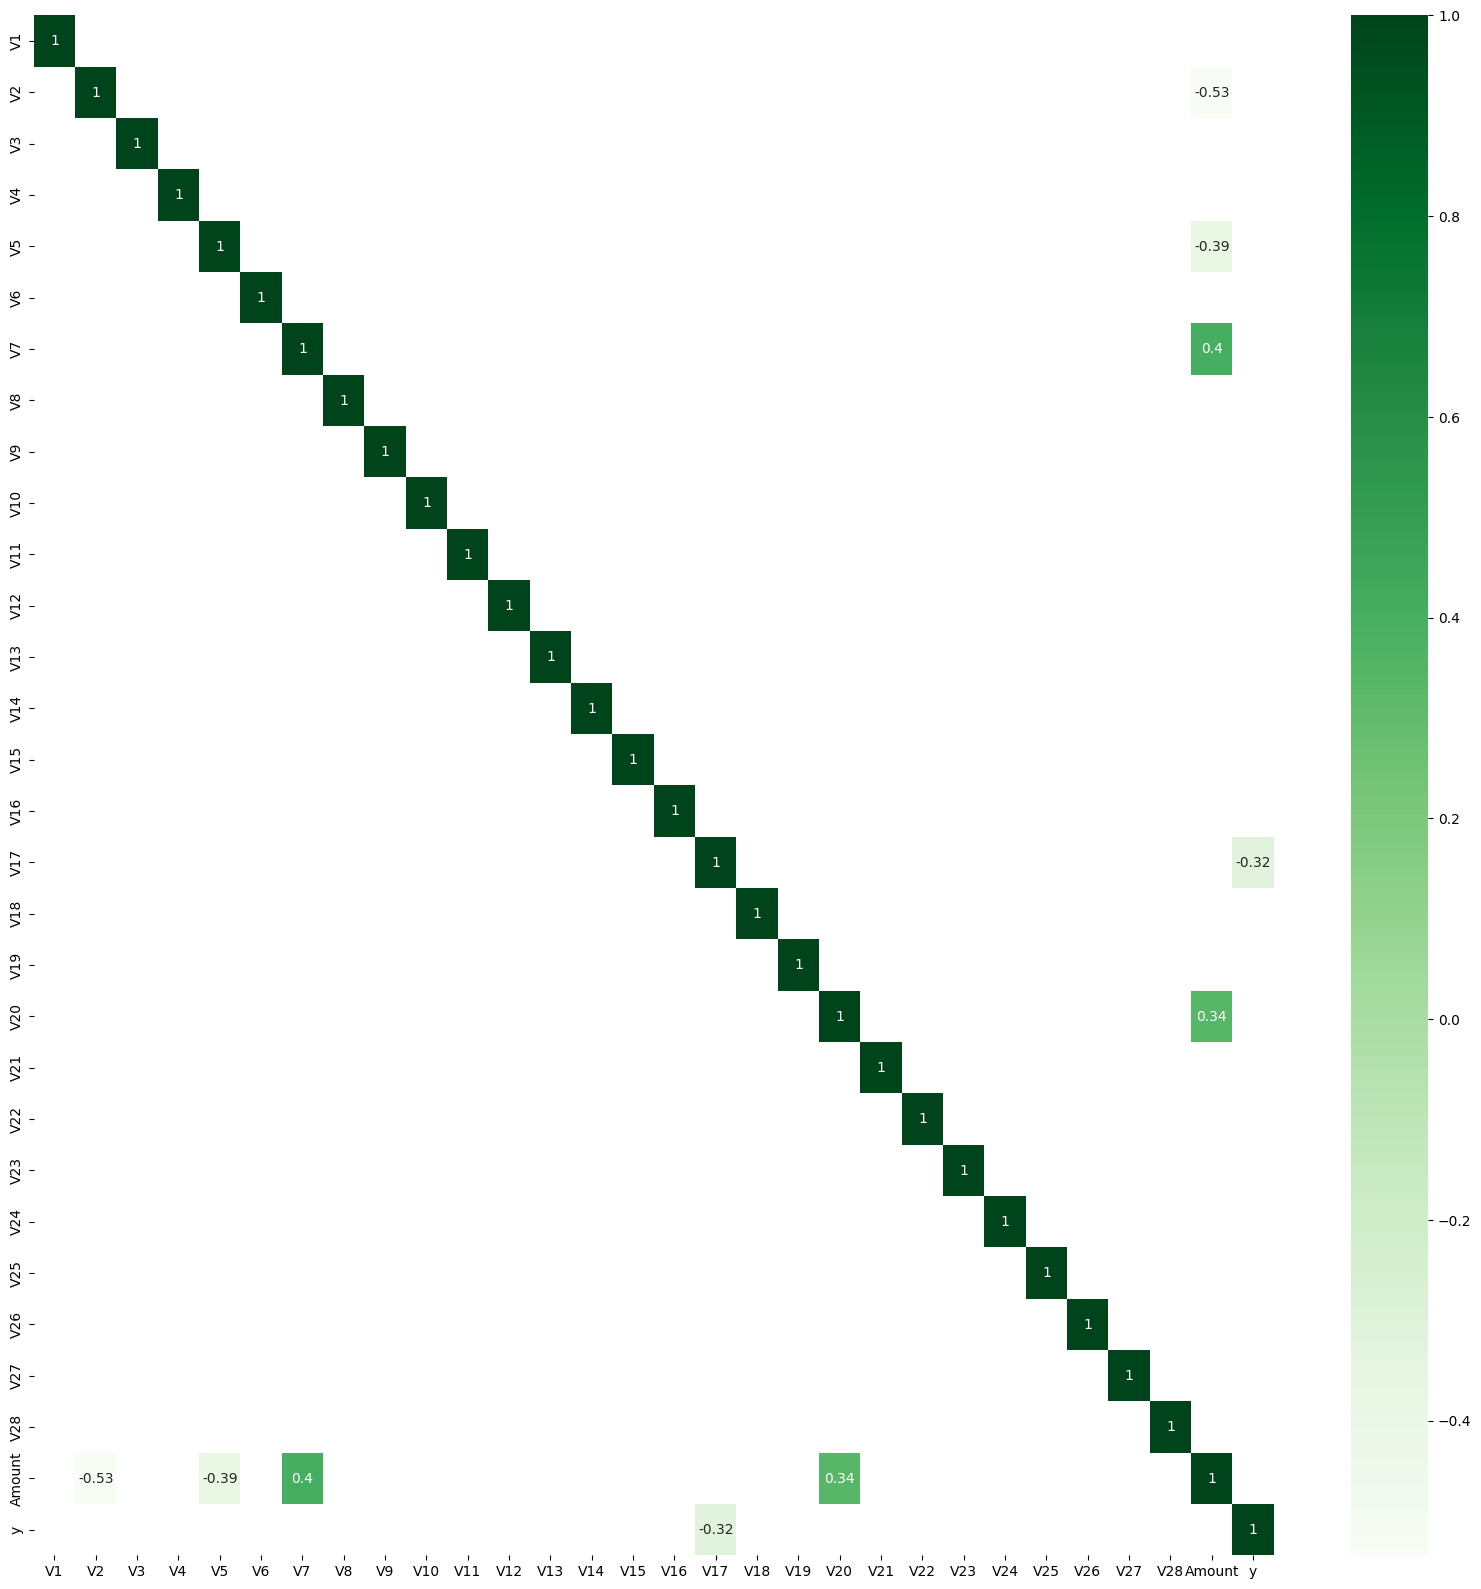

In [14]:
plt.figure(figsize=(20, 20))
sns.heatmap(
    pearson_corr[(pearson_corr >= 0.3) | (pearson_corr <= -0.3)],
    cmap="Greens",
    annot=True,
)

In [150]:
from scipy.stats import pointbiserialr

cols_with_high_corr = []
for col in data.columns.tolist():
    r, p = pointbiserialr(data.y, data[col])
    if (r >= 0.3) | (r <= -0.3):
        cols_with_high_corr.append(col)
cols_with_high_corr.remove("y")
cols_with_high_corr = np.argwhere(np.isin(data.columns.to_list(), cols_with_high_corr))[
    0
]

# Distribution of target feature

<Axes: xlabel='y', ylabel='count'>

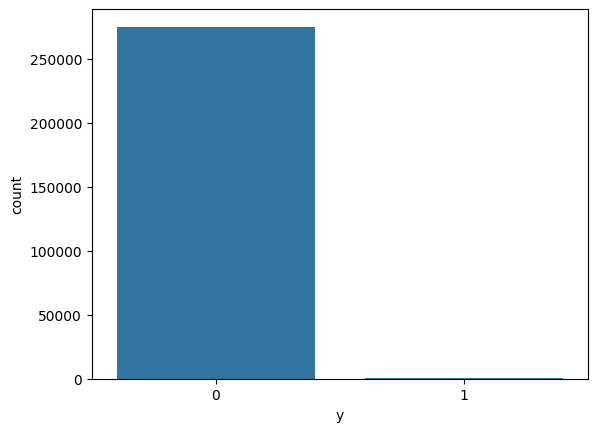

In [16]:
sns.countplot(x=data.y)

# Train and test split

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    data.drop("y", axis=1), data.y, test_size=0.33, stratify=data.y
)

# Scaling 'Amount' feature
Amount is the only column thats not normalized yet

In [18]:
X_train.Amount = (X_train.Amount - X_train.Amount.mean()) / X_train.Amount.std()

X_test.Amount = (X_test.Amount - X_test.Amount.mean()) / X_test.Amount.std()

# Feature selection with Lasso

In [19]:
lasso = Perceptron(activation="sigmoid", loss_function="logloss", l1_ratio=1, alpha=1)
lasso.fit(X_train.to_numpy(), y_train.to_numpy(), verbose=0)
lasso_results = pd.DataFrame(zip(lasso.ws, X_train.columns), columns=["ws", "column"])
lasso_results = lasso_results.sort_values(by="ws", key=abs, ascending=False)
lasso_results

,ws,column
3,-0.018,V4
13,0.014,V14
26,0.012,V27
6,-0.012,V7
0,0.011,V1
25,-0.011,V26
5,-0.010,V6
1,-0.010,V2
20,-0.009,V21
8,0.008,V9


<Axes: xlabel='ws', ylabel='column'>

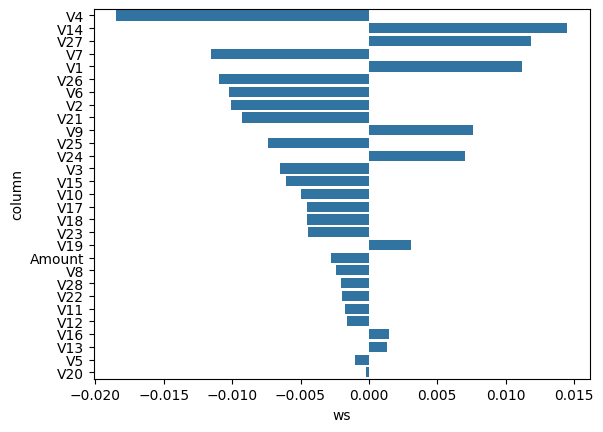

In [20]:
sns.barplot(data=lasso_results, x=lasso_results.ws, y=lasso_results.column)

# Over Sampling with SMOTE

In [21]:
sm = SMOTE()
X_res, y_res = sm.fit_resample(X_train, y_train)

In [ ]:
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()
X_test = X_train.to_numpy()
y_test = y_train.to_numpy()
X_res = X_res.to_numpy()
y_res = y_res.to_numpy()


In [129]:
def train_with_skfold(model, x, y):
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    f1_scores = []
    roc_scores = []
    for train_indexes, test_indexes in skf.split(X_train, y_train):
        model.fit(x[train_indexes], y[train_indexes])
        f1_scores.append(
            f1_score(
                y[test_indexes], model.predict(x[test_indexes]), average="weighted"
            )
        )
        roc_scores.append(
            roc_auc_score(y[test_indexes], model.predict(x[test_indexes]))
        )
    return f1_scores, roc_scores


def train_with_skfold_nn(model, x, y):
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    f1_scores = []
    roc_scores = []
    for train_indexes, test_indexes in skf.split(X_train, y_train):
        model.fit(x[train_indexes], y[train_indexes], x[test_indexes], y[test_indexes])
        f1_scores.append(
            f1_score(
                y[test_indexes], model.predict(x[test_indexes]), average="weighted"
            )
        )
        roc_scores.append(
            roc_auc_score(y[test_indexes], model.predict(x[test_indexes]))
        )
    return f1_scores, roc_scores


# Model Selection

In [159]:
def train_models(X_train, y_train, X_test, y_test, name_suf=""):
    results = {}

    dummy_clf = DummyClassifier(strategy="most_frequent")
    dummy_clf.fit(X_train, y_train)
    results[f"Dummy{name_suf}"] = {
        "name": f"Dummy Classifier{name_suf}",
        "model": dummy_clf,
        "roc_auc": roc_auc_score(y_test, dummy_clf.predict(X_test)),
        "f1_score": f1_score(y_test, dummy_clf.predict(X_test), average="weighted"),
    }
    print(results)

    lr_clf = Perceptron(activation="sigmoid", loss_function="logloss", solver="sgd")
    # lr_clf.fit(X_train.to_numpy(), y_train.to_numpy())
    f1_scores, roc_scores = train_with_skfold(lr_clf, X_train, y_train)
    results[f"Logistic{name_suf}"] = {
        "name": f"Logistic Regression{name_suf}",
        "model": lr_clf,
        "roc_auc": np.mean(
            roc_scores
        ),  # roc_auc_score(y_test, lr_clf.predict(X_test)),
        "f1_score": np.mean(
            f1_scores
        ),  # f1_score(y_test, lr_clf.predict(X_test), average="weighted"),
    }
    print(results)

    nn_clf = NNModel(
        input_dim=X_train.shape, layers=[FC(32), FC(16), FC(2, activation=Softmax())]
    )
    # nn_clf.fit(X_train, y_train, X_test, y_test, batch_size=512)
    f1_scores, roc_scores = train_with_skfold_nn(nn_clf, X_train, y_train)
    results[f"NN{name_suf}"] = {
        "name": f"Neural Network{name_suf}",
        "model": nn_clf,
        "roc_auc": np.mean(
            roc_scores
        ),  # roc_auc_score(y_test, nn_clf.predict(X_test)),
        "f1_score": np.mean(
            f1_scores
        ),  # f1_score(y_test, nn_clf.predict(X_test), average="weighted"),
    }
    print(results)

    # rf_clf = RandomForestClassifier(
    #     n_of_features=int(np.sqrt(len(X_train.columns))),
    #     bootstrap_size=int(len(X_train) * 0.001),
    #     max_depth=3,
    #     n_estimators=25
    # )
    # rf_clf.fit(X_train, y_train, X_test, y_test, 5)
    # results["RF"] = {
    #     "name": "Random Forest",
    #     "model": rf_clf,
    #     "roc_auc": roc_auc_score(y_test, rf_clf.predict(X_test)),
    #     "f1_score": f1_score(y_test, rf_clf.predict(X_test)),
    # }
    # print(results)

    # gb_clf = GradientBoostClassifier(
    #     max_features=int(np.sqrt(len(X_train.columns))),
    #     frac_of_samples=0.05,
    #     max_depth=3,
    #     n_estimators=20,
    # )
    # gb_clf.fit(X_train, y_train, X_test, y_test)
    # results["GB"] = {
    #     "name": "Grandient Boosting",
    #     "model": gb_clf,
    #     "roc_auc": roc_auc_score(y_test, gb_clf.predict(X_test)),
    #     "f1_score": f1_score(y_test, gb_clf.predict(X_test)),
    # }
    # print(results)

    return results

In [175]:
results = train_models(X_train, y_train, X_test, y_test)
results_high_corr = train_models(
    X_train[:, cols_with_high_corr],
    y_train,
    X_test[:, cols_with_high_corr],
    y_test,
    "_high_corr",
)
results_lasso_selection = train_models(
    X_train[:, np.argwhere(np.isin(data.columns, lasso_results[:10].column))[:, 0]],
    y_train,
    X_test[:, np.argwhere(np.isin(data.columns, lasso_results[:10].column))[:, 0]],
    y_test,
    "_lasso_sel",
)
results_smote = train_models(X_res, y_res, X_test, y_test, "_smote")
results_smote_high_corr = train_models(
    X_res[:, cols_with_high_corr],
    y_res,
    X_test[:, cols_with_high_corr],
    y_test,
    "_high_corr_smote",
)
results_smote_lasso_selection = train_models(
    X_res[:, np.argwhere(np.isin(data.columns, lasso_results[:10].column))[:, 0]],
    y_res,
    X_test[:, np.argwhere(np.isin(data.columns, lasso_results[:10].column))[:, 0]],
    y_test,
    "_lasso_sel_smote",
)


all_results = (
    results
    | results_high_corr
    | results_lasso_selection
    | results_smote
    | results_smote_high_corr
    | results_smote_lasso_selection
)
results_df = pd.DataFrame(all_results).T
results_df

{'Dummy': {'name': 'Dummy Classifier', 'model': DummyClassifier(strategy='most_frequent'), 'roc_auc': 0.5, 'f1_score': 0.9974284309745136}}
{'Dummy': {'name': 'Dummy Classifier', 'model': DummyClassifier(strategy='most_frequent'), 'roc_auc': 0.5, 'f1_score': 0.9974284309745136}, 'Logistic': {'name': 'Logistic Regression', 'model': <rlearn.linear_model.Perceptron object at 0x000001BC968B2FD0>, 'roc_auc': 0.805963198867152, 'f1_score': 0.9989887022870819}}
Epoch 1: Training Loss 7.96	Training Accuracy 1.00	Test Loss 0.04	Test Accuracy 0.99
Epoch 2: Training Loss 8.24	Training Accuracy 1.00	Test Loss 0.04	Test Accuracy 0.98
Epoch 3: Training Loss 8.45	Training Accuracy 1.00	Test Loss 0.05	Test Accuracy 0.98
Epoch 4: Training Loss 8.29	Training Accuracy 0.92	Test Loss 0.09	Test Accuracy 0.97
Epoch 5: Training Loss 8.22	Training Accuracy 0.92	Test Loss 0.09	Test Accuracy 0.97
Epoch 1: Training Loss 8.46	Training Accuracy 0.88	Test Loss 0.29	Test Accuracy 0.91
Epoch 2: Training Loss 8.52	Tra

,name,model,roc_auc,f1_score
Dummy,Dummy Classifier,DummyClassifier(strategy='most_frequent'),0.500,0.997
Logistic,Logistic Regression,<rlearn.linear_model.Perceptron object at 0x00...,0.806,0.999
NN,Neural Network,<rlearn.nn.NNModel object at 0x000001BC96CE7610>,0.486,0.766
Dummy_high_corr,Dummy Classifier_high_corr,DummyClassifier(strategy='most_frequent'),0.500,0.997
Logistic_high_corr,Logistic Regression_high_corr,<rlearn.linear_model.Perceptron object at 0x00...,0.642,0.998
NN_high_corr,Neural Network_high_corr,<rlearn.nn.NNModel object at 0x000001BCB22324D0>,0.478,0.898
Dummy_lasso_sel,Dummy Classifier_lasso_sel,DummyClassifier(strategy='most_frequent'),0.500,0.997
Logistic_lasso_sel,Logistic Regression_lasso_sel,<rlearn.linear_model.Perceptron object at 0x00...,0.714,0.999
NN_lasso_sel,Neural Network_lasso_sel,<rlearn.nn.NNModel object at 0x000001BC94F9D250>,0.522,0.760
Dummy_smote,Dummy Classifier_smote,DummyClassifier(strategy='most_frequent'),0.500,0.997


# Plotting results

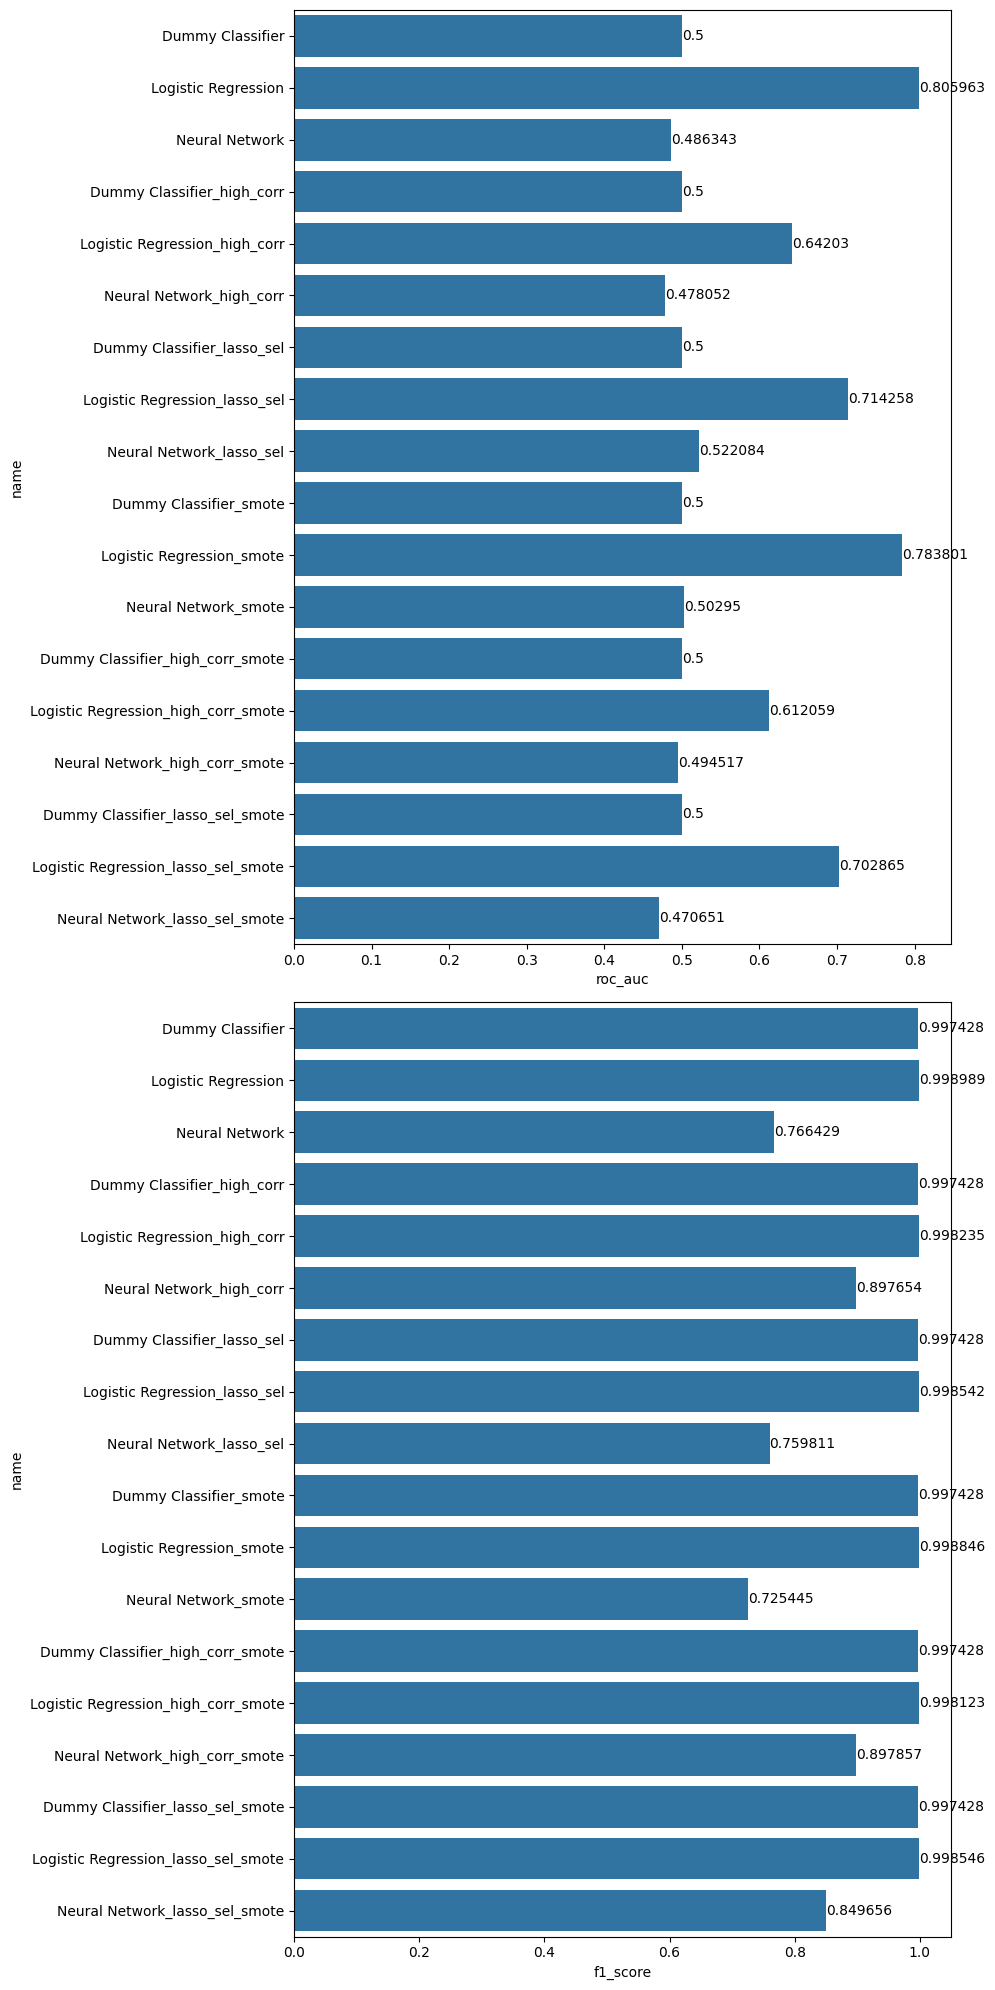

In [178]:
fig, axs = plt.subplots(nrows=2, figsize=(10, 20))
axs = axs.flatten()
plot1 = sns.barplot(data=results_df, x="roc_auc", y="name", ax=axs[0])
plot2 = sns.barplot(data=results_df, x="f1_score", y="name", ax=axs[1])
plot1.bar_label(axs[0].containers[0])
plot2.bar_label(axs[1].containers[0])
plt.tight_layout()

# Optimizing best model with Bayesian Optmization

In [ ]:
def objective(trial):
    solver = trial.suggest_categorical("solver", ["gd", "sgd", "adam"])
    lr = trial.suggest_float("lr", 1e-10, 1e10, log=True)
    alpha = trial.suggest_float("alpha", 1e-8, 1.00, log=True)
    l1_ratio = trial.suggest_float("l1_ratio", 1e-8, 1.00, log=True)
    lr_clf = Perceptron(
        activation="sigmoid",
        loss_function="logloss",
        solver=solver,
        learning_rate=lr,
        alpha=alpha,
        l1_ratio=l1_ratio,
    )
    f1_scores, auc_roc_scores = train_with_skfold(lr_clf, X_train, y_train)

    return np.mean(f1_scores)


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=15)

In [180]:
solver = study.best_params["solver"]
lr = study.best_params["lr"]
alpha = study.best_params["alpha"]
l1_ratio = study.best_params["l1_ratio"]

In [181]:
best_model = Perceptron(
    activation="sigmoid",
    loss_function="logloss",
    solver=solver,
    learning_rate=lr,
    alpha=alpha,
    l1_ratio=l1_ratio,
)
best_model.fit(X_train, y_train)

(array([-0.13988243,  1.11756911,  0.01914424,  2.72770478,  1.07197215,
        -0.28168924,  0.897977  , -0.19622488,  2.02877343, -2.65931635,
         0.04531591,  1.43087328, -0.80944764,  0.05163902,  0.4238383 ,
        -0.65590066, -0.85578821,  0.36004439, -0.15616337, -0.53839448,
         0.48954462,  0.7562819 , -0.19027895,  0.10246772,  0.2584921 ,
         0.35200297, -1.18440587, -0.57810417,  0.37177876]),
 -12.542314035330124)

In [182]:
print(classification_report(y_test, best_model.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     90813
           1       0.84      0.65      0.73       156

    accuracy                           1.00     90969
   macro avg       0.92      0.82      0.87     90969
weighted avg       1.00      1.00      1.00     90969



In [183]:
with open("model.pkl", "wb") as f:
    pickle.dump(best_model, f)